# 274to289 (1-15 Oktober)

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns

from catboost import Pool, CatBoostRegressor, cv 
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('T:\\COVID19\\Makrodaten\\Oct1-15.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_inz_AGS_274to289']
X = df.loc[:, ~df.columns.isin(['std_inz_AGS_274to289'])]
f_names = list(X.columns)
print("Number of features: ", len(X.columns))

Number of features:  969


# Feature Correlation

In [ ]:
corr = X.corr()
sns.heatmap(corr)

In [ ]:
pairs = []

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.8:
            pairs.append(corr.columns[[i,j]][0])
            pairs.append(corr.columns[[i,j]][1])
            print(corr.columns[[i,j]],corr.iloc[i,j])
            

In [ ]:
len(pairs)
len(set(pairs))

In [ ]:
#sns.heatmap(X[set(pairs)].corr())

# First CatBoost Model with 969 features

In [4]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb = model.fit(train_pool)
print("R2 of final model on all data: ",cb.score(X, Y))

R2 of final model on all data:  0.9992233131320098


In [5]:
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of final model on all data: ", eval_metric(Y, preds, 'RMSE')[0])

RMSE of final model on all data:  1.024162382373347


# SHAP VAlues

In [6]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

invalid value encountered in true_divide
invalid value encountered in true_divide


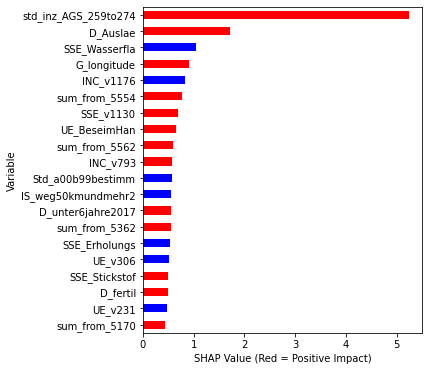

In [7]:
def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

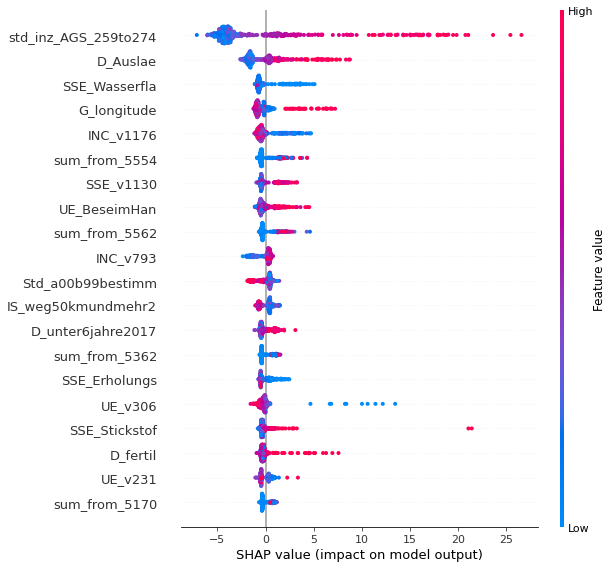

In [8]:
shap.summary_plot(shap_values_cb,X)

# Second CatBoost model with 20 most important features

In [9]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-10:][::-1]

In [10]:
# initialize Pool
train_pool_20 = Pool(X[top20feature],Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb_20 = model.fit(train_pool_20)
print("R2 of second model with top20 feature: ",cb_20.score(X[top20feature], Y))

R2 of second model with top20 feature:  0.9953350042882855


In [11]:
preds_20 = cb_20.predict(train_pool_20,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of second model on top20 data: ", eval_metric(Y, preds_20, 'RMSE')[0])

RMSE of second model on top20 data:  2.509986949376375


# Compare top 10 features of both Models

In [12]:
shap_values_cb_20 = shap.TreeExplainer(cb_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_cb_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['std_inz_AGS_259to274', 'D_Auslae', 'SSE_Wasserfla', 'G_longitude', 'INC_v1176', 'sum_from_5554', 'SSE_v1130', 'UE_BeseimHan', 'sum_from_5562', 'INC_v793'] 

 10 most important features from model with top20 features: 
 ['std_inz_AGS_259to274', 'G_longitude', 'D_Auslae', 'SSE_Wasserfla', 'IS_weg50kmundmehr2', 'SSE_Stickstof', 'UE_BeseimHan', 'D_fertil', 'sum_from_5362', 'SSE_Erholungs']


In [13]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

std_inz_AGS_259to274
D_Auslae
SSE_Wasserfla
G_longitude
UE_BeseimHan


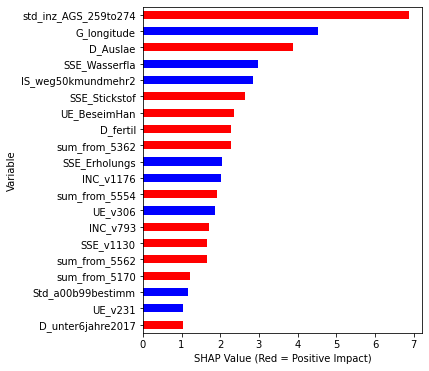

In [14]:
ABS_SHAP(shap_values_cb_20,X[top20feature]) 

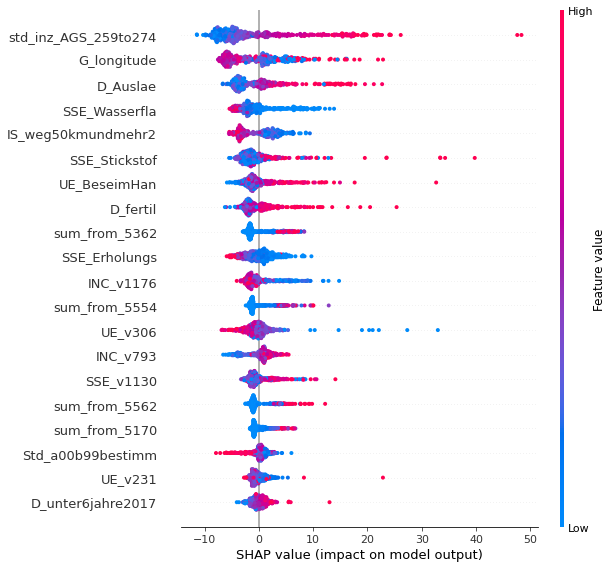

In [15]:
shap.summary_plot(shap_values_cb_20,X[top20feature])

# Hold out validation of the second model

In [16]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_cb_k_train_top20 = list(range(0,20))
r2_cb_k_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))

    
    #fit the model
    model = CatBoostRegressor(random_seed=0,
                              logging_level="Silent",
                              #iterations = scores_k.sort_values(by= "test-R2-mean")["iterations"].iloc[-1]
                             )

    cb_k = model.fit(train_pool_k)
    
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(k_test_y), preds_k, "RMSE")[0]
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, k_test_y)

    
    r2_cb_k_train_top20[i] = cb_k.score(train_pool_k)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, k_test_y)

    r2_cb_k_test_top20[i] =  cb_k.score(test_pool_k)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [17]:
print("Mean R2 of CatBoost_models on train sets with top20 features:",sum(r2_cb_k_train_top20)/len(r2_cb_k_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of CatBoost_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of CatBoost_models on test sets with top20 features:",sum(r2_cb_k_test_top20)/len(r2_cb_k_test_top20))

Mean R2 of CatBoost_models on train sets with top20 features: 0.9969900756860106
Mean R2 of linReg_modesl with top20 features:  0.504625634276753
Mean RMSE of CatBoost_models on test sets with top20 features:  25.016867746169286
Mean R2 of CatBoost_models on test sets with top20 features: 0.4897641989240359


# descriptives of top20 features

In [18]:
X[top20feature].describe()

,std_inz_AGS_259to274,D_Auslae,SSE_Wasserfla,G_longitude,INC_v1176,sum_from_5554,SSE_v1130,UE_BeseimHan,sum_from_5562,INC_v793,Std_a00b99bestimm,IS_weg50kmundmehr2,D_unter6jahre2017,sum_from_5362,SSE_Erholungs,UE_v306,SSE_Stickstof,D_fertil,UE_v231,sum_from_5170
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,26.810415,10.034916,123.133629,9.866997,13.640155,83.608482,-86.781769,13.988775,272.912720,11.951619,79.408760,11.484292,5.369076,262.715698,70.509460,-6.157605,68.331635,1.632220,15.151626,208.880295
std,19.821966,5.149191,181.269791,2.026269,5.681263,471.397949,6.361413,4.891642,1416.007935,7.726850,18.671255,3.481254,0.461510,3174.842773,56.734703,22.530609,27.160891,0.134031,3.232546,1432.920776
min,0.000000,1.900000,2.600000,6.083333,-7.500000,0.000000,-93.599998,0.000000,0.000000,-25.000000,0.000000,4.900000,4.200000,0.000000,14.000000,-69.900002,21.400000,1.060000,9.000000,0.000000
25%,13.653437,6.200000,24.700001,8.216666,10.200000,0.000000,-88.199997,10.600000,0.000000,7.300000,69.467491,9.000000,5.100000,0.000000,39.700001,-14.200000,47.500000,1.560000,13.100000,0.000000
50%,22.629042,9.200000,66.800003,9.766666,13.600000,0.000000,-87.500000,13.900000,11.000000,12.300000,78.406906,10.800000,5.400000,0.000000,52.799999,-7.700000,59.200001,1.650000,14.500000,0.000000
75%,36.430935,13.100000,131.600006,11.416667,16.500000,14.000000,-86.500000,16.900000,32.000000,16.200001,90.140533,13.300000,5.700000,28.000000,76.699997,-0.800000,88.199997,1.720000,16.100000,24.000000
max,173.247955,35.000000,1918.000000,14.983334,42.599998,5417.000000,0.000000,47.700001,14541.000000,46.000000,133.675125,24.200001,6.700000,62873.000000,384.600006,329.000000,150.699997,1.940000,28.200001,24482.000000


In [19]:
pd.DataFrame(Y).describe()

,std_inz_AGS_274to289
count,401.000000
mean,52.453857
std,36.794933
min,3.428815
25%,26.030115
50%,44.778191
75%,67.134506
max,267.674591


In [ ]:
frames = [ Y.describe(), X[top20feature].describe()]
des = pd.concat(frames, axis=1)
with pd.ExcelWriter(r"C:\Users\Constantin\Desktop\descriptives1.xlsx") as writer:  
    des.to_excel(writer, sheet_name='period 1')